# Labeled CVAE

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load pallets library from project root
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pallets import (
    images as I,
    datasets as DS,
    models as M,
    logging as L
)


# Settings

In [3]:
SAVE_NAME = 'cvae.labeled'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = 'pallets_labels.json'

TEST_SIZE = 1000
EPOCHS = 50
LR = 1e-03
BATCH_SIZE = 32


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


<Logger pallets (INFO)>

## Prepare Datasets

In [6]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotCPunksDataset(
    mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
)

# Uncomment to put entire dataset in GPU RAM
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )

INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: pallets_labels.json


In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

## Labeled Naive CVAE

In [8]:
input_dim = 24 * 24 * 222
hidden_dim = 576
latent_dim = 32
classes_dim = len(dataset._label_keys)  # 92


In [9]:
model = M.cvae.LabeledCVAE(input_dim, hidden_dim, latent_dim, classes_dim)
criterion = M.cvae.Loss()

train_losses, test_losses = M.cvae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS, conditional_loss=True
)

M.save(SAVE_NAME, model, train_losses, test_losses)

INFO | model: pallets.models.cvae.LabeledCVAE
INFO | criterion: pallets.models.cvae.Loss
INFO | learn rate: 0.001
INFO | epochs: 50
INFO | epoch 1 (  0%) loss: 1423593.125000
INFO | epoch 1 ( 35%) loss: 88232.447633
INFO | epoch 1 ( 70%) loss: 49998.685532
INFO | epoch 1 (100%) loss: 37908.333248
INFO | epoch 1 (test) loss: 6926.361279
INFO | epoch 2 (  0%) loss: 6745.611328
INFO | epoch 2 ( 35%) loss: 6538.608302
INFO | epoch 2 ( 70%) loss: 5885.737992
INFO | epoch 2 (100%) loss: 5409.353846
INFO | epoch 2 (test) loss: 3903.990690
INFO | epoch 3 (  0%) loss: 3624.968750
INFO | epoch 3 ( 35%) loss: 3598.175984
INFO | epoch 3 ( 70%) loss: 3366.212178
INFO | epoch 3 (100%) loss: 3210.196091
INFO | epoch 3 (test) loss: 2801.327785
INFO | epoch 4 (  0%) loss: 2804.128418
INFO | epoch 4 ( 35%) loss: 2578.875919
INFO | epoch 4 ( 70%) loss: 2449.443076
INFO | epoch 4 (100%) loss: 2357.474783
INFO | epoch 4 (test) loss: 2153.213619
INFO | epoch 5 (  0%) loss: 2202.340820
INFO | epoch 5 ( 35%) 

# Results

In [10]:
import random

def rand_label():
    label_idx = int(random.random() * len(dataset._labels))
    features = dataset._labels[label_idx]
    enabled_names = [k for k,v in zip(dataset._label_keys, features) if v.item() == 1]
    return features.to(device), enabled_names


In [11]:
# Generate new image

def rand_punk():
    z = torch.randn(1, latent_dim).to(device)
    # print(z.shape)
    features, names = rand_label()
    print(f"Features: {', '.join(names)}")

    with torch.no_grad():
        model.eval()
        generated_image = model.decoder(z, features.unsqueeze(0))
        # print(generated_image.shape)

    decoded_one_hot = generated_image[0]
    print(decoded_one_hot.shape)
    decoded_one_hot = decoded_one_hot[:-classes_dim].view((222, 24, 24))
    # print(decoded_one_hot.shape)
    decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
    print(f"Shape: {decoded.shape}")
    return decoded


### 5 Randoms w/ Real Labels

Features: male, shavedHead, smallShades
torch.Size([127964])
Shape: torch.Size([4, 24, 24])


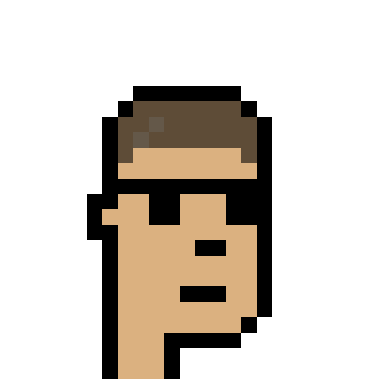

In [12]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, purpleEyeShadow, frumpyHair, mole
torch.Size([127964])
Shape: torch.Size([4, 24, 24])


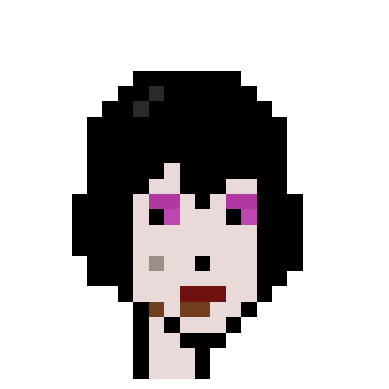

In [13]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, pigtails, purpleLipstick, earring
torch.Size([127964])
Shape: torch.Size([4, 24, 24])


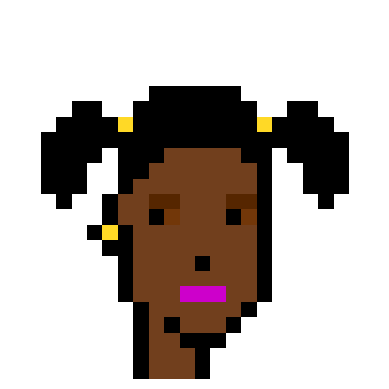

In [14]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, doRag, regularShades, mole
torch.Size([127964])
Shape: torch.Size([4, 24, 24])


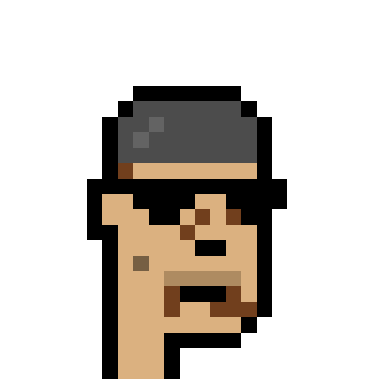

In [15]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, tassleHat, nerdGlasses
torch.Size([127964])
Shape: torch.Size([4, 24, 24])


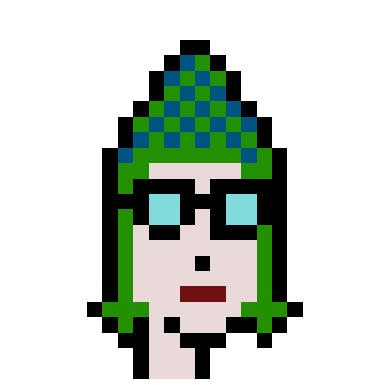

In [16]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


## Reconstruction

In [17]:
def reconstruct_punk(idx):
    punk = I.get_punk_tensor(idx)
    p = DS.rgba_to_one_hot(punk, dataset.mapper)
    p = p.unsqueeze(0)
    p = p.to(device)

    _, labels = dataset[idx]
    l = labels.unsqueeze(0)
    l = l.to(device)
    enabled_features = [k for k,v in zip(dataset._label_keys, labels) if v.item() == 1]

    model.eval()
    with torch.no_grad():
        reconstructed, mu, logvar = model.forward(p, l)

    recon_punk = reconstructed[0].cpu()
    recon_punk = recon_punk[:-classes_dim].view((222, 24, 24))
    recon_punk = DS.one_hot_to_rgba(recon_punk, dataset.mapper)

    return punk, recon_punk, enabled_features


def draw_two(img1, img2):
    page_size = 2
    view_x, view_y = 4*page_size, 2*page_size
    fig = plt.figure(figsize=(view_x, view_y))
    fig.add_subplot(1, 2, 1)
    plt.imshow(transforms.functional.to_pil_image(img1))
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(transforms.functional.to_pil_image(img2))
    plt.axis('off')
    plt.show()


### 5 Reconstructions

Features: female, rosyCheeks, darkHair, cigarette


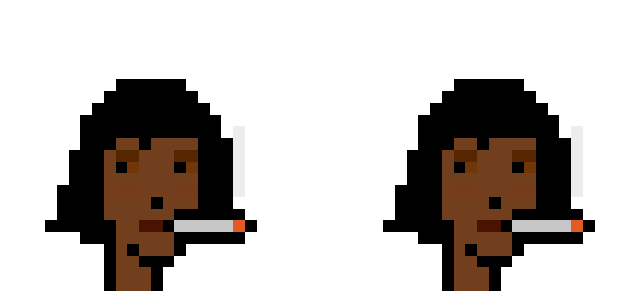

In [18]:
punk, recon_punk, features = reconstruct_punk(1000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: female, stringyHair, purpleLipstick, earring


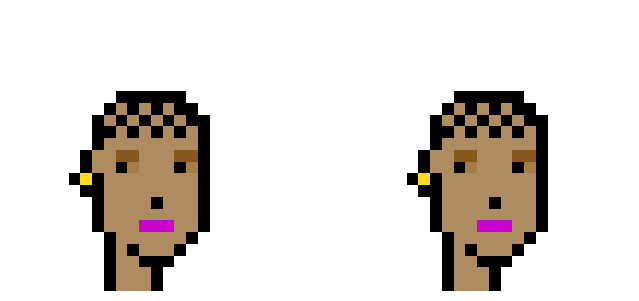

In [19]:
punk, recon_punk, features = reconstruct_punk(2001)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)


Features: female, wildWhiteHair, greenEyeShadow, hotLipstick


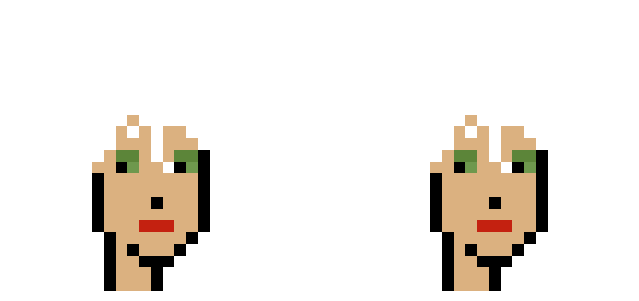

In [20]:
punk, recon_punk, features = reconstruct_punk(5000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, rosyCheeks, mustache, vr, cap, cigarette


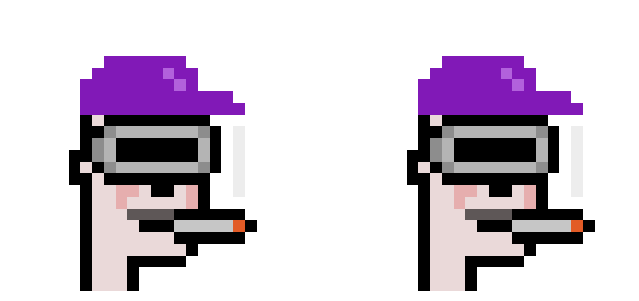

In [21]:
punk, recon_punk, features = reconstruct_punk(8000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, handlebars, bandana


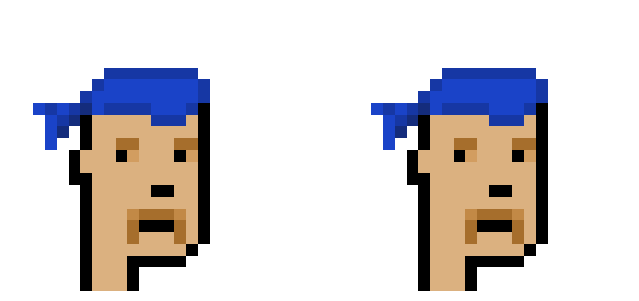

In [22]:
punk, recon_punk, features = reconstruct_punk(1337)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

## Losses

<function matplotlib.pyplot.show(close=None, block=None)>

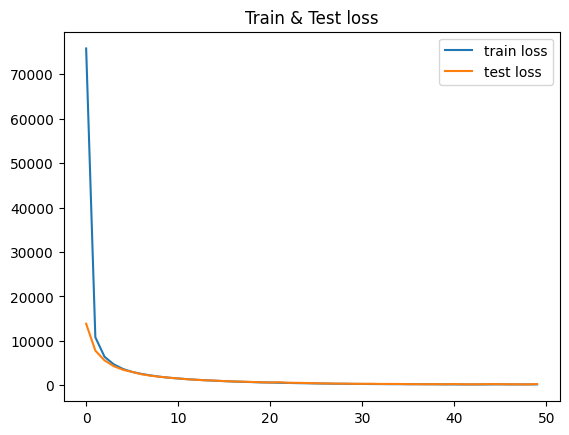

In [23]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [24]:
train_losses


[75816.66649524878,
 10818.70769268063,
 6420.392181612921,
 4714.949565914506,
 3680.791904747063,
 3017.552086796321,
 2570.441573988461,
 2224.0943350284656,
 1933.0295397170046,
 1714.5676587693235,
 1535.3550761337822,
 1383.9895837662068,
 1247.7607630736438,
 1132.95849674306,
 1034.932633582582,
 938.9329368104326,
 853.1819370350939,
 786.570814524982,
 727.2168233884987,
 659.2538031179009,
 621.8053717105946,
 577.1006844162096,
 535.8105273686402,
 488.7667427333534,
 463.1592271412518,
 420.99620391629264,
 390.8546402843286,
 357.0554353971008,
 343.77206036723254,
 318.8340080748213,
 312.34571270232505,
 291.08216211305444,
 279.7284327838438,
 262.0055263329905,
 260.21282472001747,
 242.09740960682538,
 248.2135298573379,
 230.82453079764724,
 224.17959876094304,
 203.75860419848286,
 201.64206236981332,
 189.25811703999838,
 189.25919049851439,
 188.03390394711326,
 206.51381818622562,
 217.32279638195715,
 200.27914557220242,
 197.85319524453888,
 196.73590201519906

In [25]:
test_losses


[13852.722557067871,
 7807.9813804626465,
 5602.655570983887,
 4306.4272384643555,
 3502.987632751465,
 3007.9446086883545,
 2498.8776779174805,
 2167.9041595458984,
 1928.5594968795776,
 1705.7680749893188,
 1556.8006219863892,
 1363.205768585205,
 1242.017978668213,
 1126.8000583648682,
 1064.331603050232,
 949.5111865997314,
 866.987512588501,
 821.6678743362427,
 757.8050684928894,
 682.7565588951111,
 639.8637466430664,
 687.342227935791,
 569.2424001693726,
 560.0607013702393,
 510.97585821151733,
 452.36288499832153,
 431.82012033462524,
 385.7723021507263,
 374.3928985595703,
 347.46443915367126,
 329.7143819332123,
 343.72207617759705,
 307.19319701194763,
 308.7424211502075,
 301.3441495895386,
 265.41312050819397,
 256.13358902931213,
 245.04453706741333,
 258.32641077041626,
 230.1136291027069,
 284.0440423488617,
 228.04113841056824,
 225.56519484519958,
 243.68196153640747,
 271.4093405008316,
 255.89724028110504,
 228.2203551530838,
 236.48502254486084,
 207.733510732650